<a href="https://colab.research.google.com/github/sergiopicascia/market-basket-analysis/blob/main/Market_basket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd

# Data Import

In [2]:
# Connection with Kaggle API
files.upload() # Upload kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Download dataset
! kaggle datasets download -d ashirwadsangwan/imdb-dataset

 99% 1.42G/1.44G [00:12<00:00, 122MB/s]
100% 1.44G/1.44G [00:13<00:00, 119MB/s]


In [4]:
# Unzip files
! unzip imdb-dataset.zip -d imdb

Archive:  imdb-dataset.zip
  inflating: imdb/name.basics.tsv.gz  
  inflating: imdb/name.basics.tsv/name.basics.tsv  
  inflating: imdb/title.akas.tsv.gz  
  inflating: imdb/title.akas.tsv/title.akas.tsv  
  inflating: imdb/title.basics.tsv.gz  
  inflating: imdb/title.basics.tsv/title.basics.tsv  
  inflating: imdb/title.principals.tsv.gz  
  inflating: imdb/title.principals.tsv/title.principals.tsv  
  inflating: imdb/title.ratings.tsv.gz  
  inflating: imdb/title.ratings.tsv/title.ratings.tsv  


In [5]:
# Install pyspark
!pip install pyspark

     |████████████████████████████████| 212.3MB 68kB/s 
     |████████████████████████████████| 204kB 13.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=c370d01e02427f09d48484bda86ac685a998d0057e4fa6e14e2cc562153d9d06
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


# Data Manipulation

In [6]:
# Create a PySpark DataFrame
from pyspark.sql import SparkSession

path = r'/content/imdb/title.principals.tsv/title.principals.tsv'
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
principals = (spark.read.options(header=True, delimiter='\t', inferSchema = True)
              .format('csv').load(path))

principals.show(10)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
|tt0000003|       1|nm0721526|       director|                  \N|         \N|
|tt0000003|       2|nm5442194|       producer|            producer|         \N|
|tt0000003|       3|nm1335271|       composer|                  \N|         \N|
|tt0000003|       4|nm5442200|         editor|                  \N|         \N|
|tt0000004|       1|nm0721526|       dir

In [7]:
# Creating a lazy evaluation view of principals
principals.createOrReplaceTempView("principals")

# Performing a query in order to retrieve only actors/actresses and 
# the movie in which they partecipated
principals = spark.sql("SELECT tconst, nconst FROM principals WHERE (category = 'actor' or category = 'actress')")
principals.show(10)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000005|nm0443482|
|tt0000005|nm0653042|
|tt0000007|nm0179163|
|tt0000007|nm0183947|
|tt0000008|nm0653028|
|tt0000009|nm0063086|
|tt0000009|nm0183823|
|tt0000009|nm1309758|
|tt0000011|nm3692297|
|tt0000014|nm0166380|
+---------+---------+
only showing top 10 rows



In [8]:
# Count of rows in dataframe
principals.count()

14818798

In [9]:
# Count of unique rows in dataframe
principals.dropDuplicates(['tconst', 'nconst']).count() # Try with distinct

14818203

In [10]:
# Drop duplicates and rename columns
principals = principals.dropDuplicates(['tconst', 'nconst']) \
            .withColumnRenamed('tconst', 'movie') \
            .withColumnRenamed('nconst', 'actor')

principals.show(10)

+---------+---------+
|    movie|    actor|
+---------+---------+
|tt0000091|nm0617588|
|tt0000165|nm0278321|
|tt0000609|nm0215516|
|tt0000768|nm0647719|
|tt0000781|nm0492757|
|tt0000870|nm0038106|
|tt0000951|nm0088881|
|tt0001018|nm0007221|
|tt0001046|nm0424530|
|tt0001067|nm0364516|
+---------+---------+
only showing top 10 rows



In [11]:
# Count number of unique movies and actors
n_movies = principals.dropDuplicates(['movie']).count()
n_actors = principals.dropDuplicates(['actor']).count()

print("The dataframe contains {} movies (baskets) and {} actors (items).".format(n_movies, n_actors))

The dataframe contains 3598991 movies (baskets) and 1867043 actors (items).


# Exploratory Data Analysis

In [12]:
from pyspark.sql.functions import collect_set

# Grouping by movie and extrapolating baskets (movies) of items (actors)
baskets = principals.groupBy('movie').agg(collect_set('actor').alias('actors'))
baskets.createOrReplaceTempView('baskets')
baskets.show(10, truncate=False)

+---------+--------------------------------------------------------------------------------------------------------------+
|movie    |actors                                                                                                        |
+---------+--------------------------------------------------------------------------------------------------------------+
|tt0001170|[nm0161366, nm0865178, nm0001908, nm0607104, nm0639631, nm0693055, nm0930290, nm0355582, nm0789632, nm1400009]|
|tt0001664|[nm0616729, nm0806961, nm0492757, nm0424530, nm1190291]                                                       |
|tt0001732|[nm0532996, nm0367556, nm0531759, nm0790137, nm0681933, nm0681931]                                            |
|tt0001887|[nm0681933]                                                                                                   |
|tt0002253|[nm0537556, nm0524306, nm0115524, nm0366008, nm0000859, nm0043018, nm0681933]                                 |
|tt0002473|[nm05

In [13]:
# Import data about movies and actors
titles = (spark.read.options(header=True, delimiter='\t', inferSchema = True)
          .format('csv').load(r'/content/imdb/title.basics.tsv/title.basics.tsv'))

names = (spark.read.options(header=True, delimiter='\t', inferSchema = True)
          .format('csv').load(r'/content/imdb/name.basics.tsv/name.basics.tsv'))

# Creating lazy evaluation views of movies and actors
titles.createOrReplaceTempView("titles")
names.createOrReplaceTempView("names")

titles.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [14]:
names.show(10)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
|nm0000006| Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0038109,tt00368...|
|nm0000007|Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0043265,tt00338...|
|nm0000008|  Marlon Brando|     1924|     2004|actor,soundtrack,...|tt0070849,tt00787...|
|nm0000009

   n_movies  startYear
0         1     1881.0
1         1     1888.0
2         3     1890.0
3         4     1891.0
4         1     1892.0


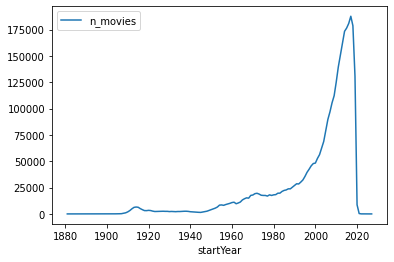

In [15]:
# Number of movies for year
query = r"""SELECT COUNT(tconst) AS n_movies, startYear 
          FROM baskets INNER JOIN titles ON movie = tconst
          GROUP BY startYear"""
movies_by_year = spark.sql(query)
movies_by_year_pd = movies_by_year.orderBy(movies_by_year['startYear'].asc()).toPandas()
movies_by_year_pd['startYear'] = pd.to_numeric(movies_by_year_pd['startYear'], errors='coerce').dropna()
print(movies_by_year_pd.head())

# Drop last rows (year = 2115, NAs)
movies_by_year_pd.drop(movies_by_year_pd.tail(2).index, inplace=True)
movies_by_year_pd.plot(x='startYear', y='n_movies')

      genre    count
22    Drama  1509959
5    Comedy   974381
7     Short   558039
13  Romance   516433
27   Family   274830


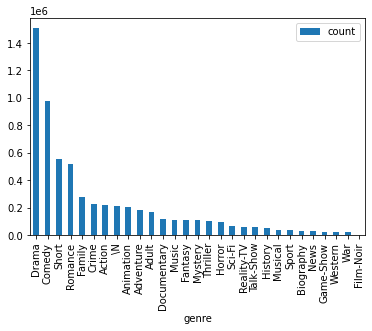

In [16]:
# Number of movies per genre
query = """SELECT tconst, genres
        FROM baskets INNER JOIN titles ON movie = tconst
        WHERE genres IS NOT NULL"""
movies_genre = spark.sql(query)
movies_genre = movies_genre.select('genres').rdd.flatMap(lambda x: (x[0].split(','))).map(lambda x: (x, 1))
movies_genre = movies_genre.reduceByKey(lambda a, b: a+b)
movies_genre_pd = spark.createDataFrame(movies_genre).toPandas()
movies_genre_pd.rename(columns={'_1': 'genre', '_2': 'count'}, inplace=True)
movies_genre_pd.sort_values('count', ascending=False, inplace=True)
print(movies_genre_pd.head())
movies_genre_pd.plot.bar(x='genre')

    startYear  runtimeMinutes
4      1912.0            17.0
5      1912.0            17.0
6      1912.0            18.0
14     1914.0            16.0
15     1914.0           300.0


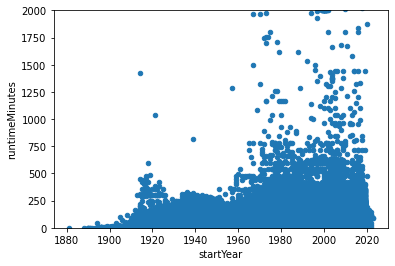

In [17]:
# Duration and year
query = """SELECT startYear, runtimeMinutes
        FROM baskets INNER JOIN titles ON movie = tconst"""
year_duration = spark.sql(query)
year_duration_pd = year_duration.toPandas()
year_duration_pd = year_duration_pd.apply(pd.to_numeric, errors='coerce').dropna()
print(year_duration_pd.head())
year_duration_pd.plot.scatter(x='startYear', y='runtimeMinutes', ylim=(0, 2000))

# Apriori

In [18]:
# Defining support threshold
supp = n_movies * 0.0003
supp

1079.6972999999998

### Singletons

In [19]:
# Use map on each item to generate singletons
singletons = principals.select('actor').rdd.map(lambda item: (item[0], 1))

In [20]:
# Reduce by item and count occurrences of items
singletons = singletons.reduceByKey(lambda a, b: a+b).toDF(['actor', 'count'])

In [21]:
# Find frequent items according to threshold
frequent_1 = singletons.filter(singletons['count'] >= supp)
frequent_1.orderBy(frequent_1['count'].desc()).show()

+----------+-----+
|     actor|count|
+----------+-----+
|nm10120013| 5746|
| nm0151534| 4200|
| nm0192504| 3987|
| nm0555829| 3917|
| nm0525123| 3817|
| nm0708802| 3770|
| nm0609391| 3714|
| nm0136994| 3708|
| nm0239134| 3568|
| nm0164818| 3551|
| nm5782599| 3537|
| nm0575114| 3480|
| nm0368990| 3359|
| nm0115836| 3302|
| nm4828538| 3255|
| nm0576967| 3255|
| nm9615265| 3254|
| nm0764156| 3241|
| nm0265155| 3209|
| nm2588610| 3206|
+----------+-----+
only showing top 20 rows



In [22]:
# Generate list of frequent singletons
L1 = frequent_1.rdd.map(lambda x: x[0]).collect()
print(len(L1))

816


### K-uples

In [23]:
import itertools

def gen_kuples(x, k, Lk=None):
  """ Generate k-uples of frequent items.
  x: row of rdd (basket)
  k: cardinality of combinations to find
  Lk: set of frequent (k-1)-uples
  """

  # Retrieve basket as list of items
  basket = sorted(x[1])

  # Check if the basket contains more than k-1 items
  if len(basket)<k:
    return None

  # List of frequent items inside the basket
  cand_items = [item for item in basket if item in L1]

  # Generate candidate k-uples
  if len(cand_items)>=k:
    Ck = set(itertools.combinations(cand_items, k))
  else:
    return None 

  # Return in case of pairs (k=2), no further checks required
  if k == 2:
    return Ck

  # Generate k-uples of frequent (k-1)-uples
  kuples = [kuple for kuple in Ck if set(itertools.combinations(kuple, k-1)).issubset(Lk)]

  return kuples

In [24]:
import copy

L = []
F_1 = []
for row in frequent_1.collect():
  t = row[0]
  c = row[1]
  F_1.append((t, c))
L.append(F_1)

Lk = copy.deepcopy(L1)

try:
  # Iterate over k
  for k in range(2, 20):
    print('\nk =', k, '\n')
    
    # Generate a list of k-uples that are frequent in L(k-1)
    kuples = list(filter(None, baskets.rdd.map(lambda x: gen_kuples(x, k, Lk)).collect()))
    kuples = spark.sparkContext.parallelize(kuples)
    
    # Add count 1 to each k-uple
    kuples = kuples.flatMap(lambda x: x).map(lambda x: (x, 1))
    
    # Reduce by key counting the number of occurrences of the k-uple
    kuples = kuples.reduceByKey(lambda a, b: a+b).toDF([str(k)+'-uple', 'count'])
    
    # Retrieve only the k-uples with count above the support
    frequent_k = kuples.filter(kuples['count'] >= supp)

    F = []
    for row in frequent_k.collect():
      t = tuple(item for item in row[0])
      c = row[1]
      F.append((t, c))
    L.append(F)   

    print(frequent_k.orderBy(frequent_k['count'].desc()).show(10, truncate = False))

    # Generate the list of frequent k-uples
    Lk = set(frequent_k.rdd.map(lambda x: tuple(x[0])).collect())
    print('\nNumber of', k, '-uples with frequent items: ', len(Lk), '\n\n##########')

except:
  print('There are no sequence of elements with', k, 'items.')


k = 2 

+-----------------------+-----+
|2-uple                 |count|
+-----------------------+-----+
|{nm0525123, nm0609391} |3557 |
|{nm10120013, nm9615265}|3253 |
|{nm4828538, nm9615265} |3253 |
|{nm10120013, nm4828538}|3253 |
|{nm0368990, nm2588610} |3200 |
|{nm0136994, nm0164818} |2872 |
|{nm0136994, nm0717265} |2770 |
|{nm0164818, nm0717265} |2680 |
|{nm1118516, nm1801750} |2490 |
|{nm1801750, nm4028609} |2488 |
+-----------------------+-----+
only showing top 10 rows

None

Number of 2 -uples with frequent items:  235 

##########

k = 3 

+----------------------------------+-----+
|3-uple                            |count|
+----------------------------------+-----+
|{nm10120013, nm4828538, nm9615265}|3253 |
|{nm0136994, nm0164818, nm0717265} |2564 |
|{nm1118516, nm1801750, nm4028609} |2488 |
|{nm0004471, nm10120013, nm4685592}|2482 |
|{nm1318798, nm1421364, nm2091678} |2363 |
|{nm0865945, nm1421364, nm2091678} |2361 |
|{nm0865945, nm1318798, nm2091678} |2361 |
|{nm0865945, n

# Association Rules


In [25]:
# Transform list of tuples into dictionary
for i in range(len(L)):
  L[i] = dict(L[i])

In [26]:
cols = ['X', 'Y', 'Confidence', 'Lift']
a_rules = pd.DataFrame(columns=cols)

# For each (quintuple, count)
for quintuple, n_XY in L[4].items():
  suppXY = n_XY/n_movies # Support

  k = 4
  for i in reversed(range(1, k+1)):

    for X in set(itertools.combinations(sorted(quintuple), i)):

      if len(X) == 1:
        X = X[0]
      
      n_X = L[i-1][X]
      suppX = n_X/n_movies
      
      Y = [item for item in quintuple if item not in X]

      if len(Y) == 1:
        Y = Y[0]
        suppY = L[0][Y]/n_movies
      else:
        Y = tuple(Y)
        suppY = L[len(Y)-1][Y]/n_movies

      confidence = n_XY/n_X
      lift = suppXY/(suppX*suppY)

      a_rules = a_rules.append(pd.Series([X, Y, confidence, lift],
                                         index = cols), ignore_index=True)


In [31]:
a_rules.sort_values('Confidence').head(20)

,X,Y,Confidence,Lift
89,nm9870562,"(nm10001134, nm2828569, nm9870565, nm9871162)",0.378314,1223.314412
86,nm2828569,"(nm10001134, nm9870562, nm9870565, nm9871162)",0.450425,1456.491704
84,"(nm2828569, nm9870562)","(nm10001134, nm9870565, nm9871162)",0.450790,1457.671527
87,nm9870565,"(nm10001134, nm2828569, nm9870562, nm9871162)",0.683241,2209.325353
77,"(nm9870562, nm9870565)","(nm10001134, nm2828569, nm9871162)",0.743984,2405.742647
56,nm4013410,"(nm5426054, nm7356625, nm7665578, nm8905840)",0.757168,1563.419201
88,nm9871162,"(nm10001134, nm2828569, nm9870562, nm9870565)",0.808279,2613.646333
61,"(nm2828569, nm9870562, nm9870565, nm9871162)",nm10001134,0.808279,2613.646333
66,"(nm9870562, nm9870565, nm9871162)","(nm10001134, nm2828569)",0.808279,2613.646333
67,"(nm2828569, nm9870565, nm9871162)","(nm10001134, nm9870562)",0.808279,2613.646333


In [32]:
a_rules.sort_values('Confidence').tail(20)

,X,Y,Confidence,Lift
43,"(nm4013410, nm5426054, nm8905840)","(nm7356625, nm7665578)",1.0,2064.825588
42,"(nm5426054, nm7665578, nm8905840)","(nm4013410, nm7356625)",1.0,2064.825588
41,"(nm5426054, nm7356625, nm8905840)","(nm4013410, nm7665578)",1.0,2064.825588
40,"(nm4013410, nm5426054, nm7665578)","(nm7356625, nm8905840)",1.0,2064.825588
39,"(nm4013410, nm7665578, nm8905840)","(nm5426054, nm7356625)",1.0,2064.825588
38,"(nm4013410, nm7356625, nm7665578)","(nm5426054, nm8905840)",1.0,2064.825588
37,"(nm5426054, nm7356625, nm7665578)","(nm4013410, nm8905840)",1.0,2064.825588
36,"(nm4013410, nm7356625, nm8905840)","(nm5426054, nm7665578)",1.0,2064.825588
46,"(nm4013410, nm8905840)","(nm5426054, nm7356625, nm7665578)",1.0,2064.825588
35,"(nm7356625, nm7665578, nm8905840)","(nm4013410, nm5426054)",1.0,2064.825588


In [33]:
a_rules.sort_values('Lift').head(20)

,X,Y,Confidence,Lift
89,nm9870562,"(nm10001134, nm2828569, nm9870565, nm9871162)",0.378314,1223.314412
62,"(nm10001134, nm2828569, nm9870565, nm9871162)",nm9870562,1.000000,1223.314412
86,nm2828569,"(nm10001134, nm9870562, nm9870565, nm9871162)",0.450425,1456.491704
64,"(nm10001134, nm9870562, nm9870565, nm9871162)",nm2828569,1.000000,1456.491704
84,"(nm2828569, nm9870562)","(nm10001134, nm9870565, nm9871162)",0.450790,1457.671527
70,"(nm10001134, nm9870565, nm9871162)","(nm2828569, nm9870562)",1.000000,1457.671527
56,nm4013410,"(nm5426054, nm7356625, nm7665578, nm8905840)",0.757168,1563.419201
33,"(nm5426054, nm7356625, nm7665578, nm8905840)",nm4013410,1.000000,1563.419201
59,nm5426054,"(nm4013410, nm7356625, nm7665578, nm8905840)",0.997710,2060.097882
34,"(nm4013410, nm7356625, nm7665578, nm8905840)",nm5426054,1.000000,2060.097882


In [34]:
a_rules.sort_values('Lift').tail(20)

,X,Y,Confidence,Lift
26,nm5800197,"(nm10625684, nm3480406, nm8230796, nm8284549)",1.0,3073.433817
24,"(nm10625684, nm8230796)","(nm3480406, nm5800197, nm8284549)",1.0,3073.433817
23,"(nm3480406, nm5800197)","(nm10625684, nm8230796, nm8284549)",1.0,3073.433817
22,"(nm5800197, nm8230796)","(nm10625684, nm3480406, nm8284549)",1.0,3073.433817
21,"(nm10625684, nm3480406)","(nm5800197, nm8230796, nm8284549)",1.0,3073.433817
20,"(nm10625684, nm8284549)","(nm3480406, nm5800197, nm8230796)",1.0,3073.433817
19,"(nm3480406, nm8230796)","(nm10625684, nm5800197, nm8284549)",1.0,3073.433817
6,"(nm10625684, nm5800197, nm8230796)","(nm3480406, nm8284549)",1.0,3073.433817
18,"(nm10625684, nm5800197)","(nm3480406, nm8230796, nm8284549)",1.0,3073.433817
16,"(nm3480406, nm8284549)","(nm10625684, nm5800197, nm8230796)",1.0,3073.433817
